1. ~~Simple plot of the domain (Mesh and extent) See the COMT project page for a good example. [Figure 1ab](https://ioos.us/comt/projects/gom_hypoxia)~~
2. Plot of one field SST, SSH, etc (Maybe that is best in a second notebook to avoid cluttering this one.)
3. ~~Simple stats on characteristics of the model (resolution, grid type, vertical levels, time step)~~
4. Check to see if model is available on Regional Portal (not sure what that entails)
5. Check to see if model is registered in IOOS Catalog

# IOOS models


We have many different grid types may or may not conform to standards, like UGRID and SGRID, may be 1-D or 2-D coords. In order to be able to extract then without worrying about the underlying nature of the grids let's use `gridgeo` to obtain a GeoJSON representation of the grid.

In [1]:
from gridgeo import GridGeo
from netCDF4 import Dataset


models = {
    'CNAPS':
    {
        'url': 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
    'NECOFS':
    {
        'url': 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_FVCOM_OCEAN_MASSBAY_FORECAST.nc',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
    'ESPRESSO':
    {
        'url': 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
        'var': {'standard_name': 'sea_water_potential_temperature'},
    },
    'WCOFS':
    {
        'url': 'http://data.oceansmap.com/thredds/dodsC/EDS/WCOFS',
        'var': {'long_name': 'model surface potential temperature'},
    },
    'OSU_ROMS':
    {
        'url': 'http://ona.coas.oregonstate.edu:8080/thredds/dodsC/NANOOS/OCOS',
        'var': {'standard_name': 'sea_water_potential_temperature'}
    },
    'NYHOPS':
    {
        'url': 'http://colossus.dl.stevens-tech.edu:8080/thredds/dodsC/latest/Complete_gcmplt.nc',
        'var': {'standard_name': 'sea_water_temperature'},
    },
    'Columbia River':
    {
        'url': 'http://amb6400b.stccmop.org:8080/thredds/dodsC/model_data/forecast.nc',
        'var': {'standard_name': 'sea_surface_temperature'},
    },
    'WestCoastUCSC':
    {
        'url': 'http://oceanmodeling.pmc.ucsc.edu:8080/thredds/dodsC/ccsra_2016a_phys_agg_zlevs/fmrc/CCSRA_2016a_Phys_ROMS_z-level_(depth)_Aggregation_best.ncd',
        'var': {'long_name': 'potential temperature'},
    },
}

In [2]:
for model, value in models.items():
    nc = Dataset(value['url'])
    models[model].update({'nc': nc})
    models[model].update({'grid': GridGeo(nc, **value['var'])})

The `plot_grid` is a quick way to create a static figure for the grid.
We can prettify it later. 

In [3]:
%matplotlib inline

import cartopy.crs as ccrs
from cartopy.feature import COLORS, NaturalEarthFeature

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import numpy as np

from pandas import DataFrame


LAND = NaturalEarthFeature('physical', 'land', '10m',
                           edgecolor='face',
                           facecolor=COLORS['land'])

def plot_grid(grid, color='darkgray'):
    polygon = PolyCollection(
        grid.polygons,
        alpha=0.2,
        facecolor='none',
        edgecolor='gray',
        transform=ccrs.Geodetic(),
    )

    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={'projection': ccrs.PlateCarree()},
    )
    ax.add_feature(LAND, zorder=0, edgecolor='black')
    ax.set_title(grid.mesh)

    if grid.mesh in ['unknown_1d', 'unknown_2d', 'sgrid']:
        if grid.mesh == 'unknown_1d':
            x, y = np.meshgrid(grid.x, grid.y)
        ax.plot(
            grid.x, grid.y, color,
            grid.x.T, grid.y.T, color,
            alpha=0.25,
        )
    elif grid.mesh == 'ugrid':
        kw = dict(linestyle='-', alpha=0.25, color=color)
        ax.triplot(grid.triang, **kw)
    else:
        raise ValueError(f'Unrecognized grid type {grid.mesh}.')
        

    return fig, ax


def cftime(time):
    from netCDF4 import num2date
    times = time[:]
    calendar = getattr(time, 'calendar', 'standard')
    return num2date(times[0:2], time.units, calendar=calendar)


def _vlevel(var):
    try:
        vlevel = var.z_axis().shape[0]
    except ValueError:
        vlevel = None
    return vlevel


def _tstep(var):
    try:
        tstep = np.diff(cftime(var.t_axis()))[0].total_seconds()
        tstep = int(tstep)
    except ValueError:
        tstep = None
    return tstep


def _res(var):
    try:
        x = var.x_axis()[:]
        y = var.y_axis()[:]
        if x.ndim == 2 and y.ndim == 2:
            res = np.max(
                [
                    np.max(np.diff(x, axis=0)), np.max(np.diff(x, axis=1)),
                    np.max(np.diff(y, axis=0)), np.max(np.diff(y, axis=1))
                ]
            )
        elif x.ndim == 1 and y.ndim == 1:
            res = np.max(
                [
                    np.max(np.diff(x)), np.max(np.diff(y))
                ]
            )
        else:
            res = 'unknown'
    except ValueError:
        res = None
    return res


def get_stats(nc, name, **kwars):
    # TODO: return an HTML table for folium popups
    import numpy as np
    from gridgeo.cfvariable import CFVariable
    
    var = CFVariable(nc, **kwars)
    
    vlevel = _vlevel(var)
    tstep = _tstep(var)
    res = _res(var)
    d = {
        'resolution': f'{res:0.2f} meters',
        'grid type': f'{var.topology()}',
        'vertical levels': f'{vlevel}',
        'time step': f'{tstep} seconds',
    }
    
    df = DataFrame.from_dict(d, orient='index')
    df.columns = [name]
    return df


def to_html(df):
    classes = 'table table-striped table-hover table-condensed table-responsive'
    return df.to_html(classes=classes)

,CNAPS
resolution,0.10 meters
grid type,unknown_2d
vertical levels,36
time step,10800 seconds


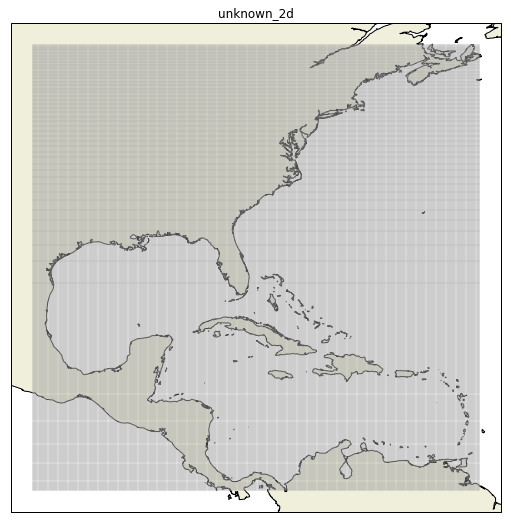

In [4]:
name = 'CNAPS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,NECOFS
resolution,1.83 meters
grid type,ugrid
vertical levels,10
time step,3712 seconds


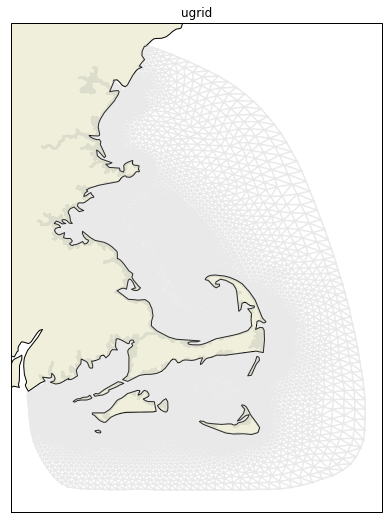

In [5]:
name = 'NECOFS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,ESPRESSO
resolution,0.06 meters
grid type,sgrid
vertical levels,36
time step,86400 seconds


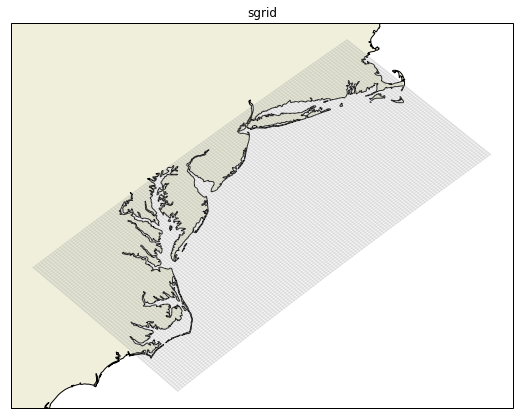

In [6]:
name = 'ESPRESSO'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,WCOFS
resolution,0.03 meters
grid type,sgrid
vertical levels,None
time step,None seconds


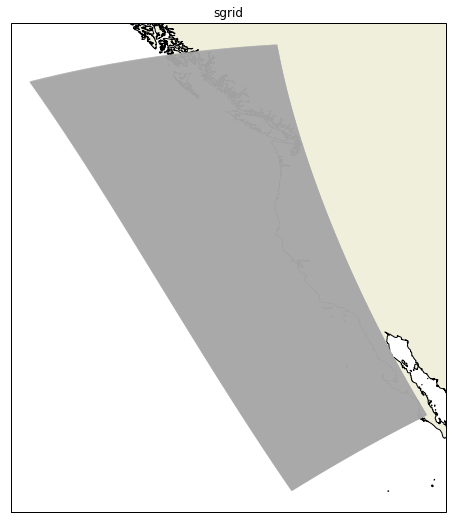

In [7]:
# FIXME: WCOFS provides just a few time-steps and only the surface fields.
# That makes it hard to derive the properties we want using the OPeNDAP endpoint.
name = 'WCOFS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,OSU_ROMS
resolution,0.03 meters
grid type,unknown_2d
vertical levels,40
time step,7200 seconds


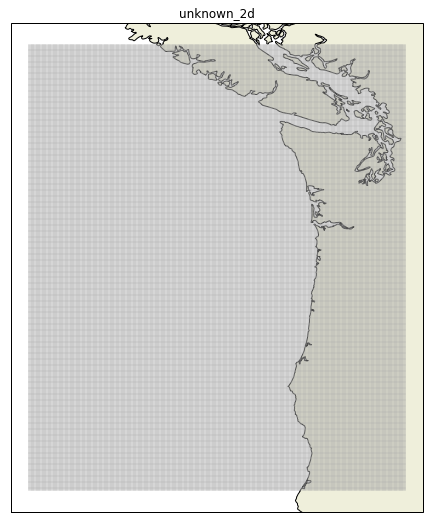

In [8]:
name = 'OSU_ROMS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,NYHOPS
resolution,0.12 meters
grid type,unknown_2d
vertical levels,11
time step,None seconds


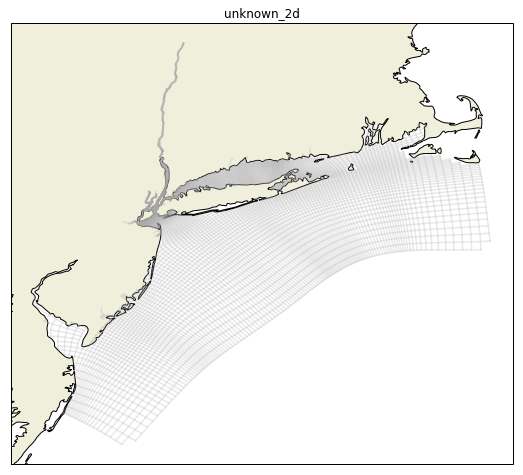

In [9]:
# FIXME: time is not in the variable coordinates :-(
name = 'NYHOPS'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,Columbia River
resolution,0.49 meters
grid type,ugrid
vertical levels,None
time step,None seconds


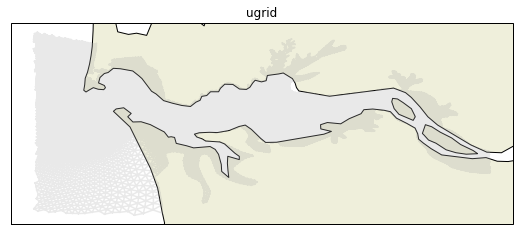

In [10]:
name = 'Columbia River'
model = models[name]

# FIXME: time is not in the variable coordinates
# and we cannot get the vertical levels from the surface temperature :-/
fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

,WestCoastUCSC
resolution,0.10 meters
grid type,unknown_2d
vertical levels,11
time step,86400 seconds


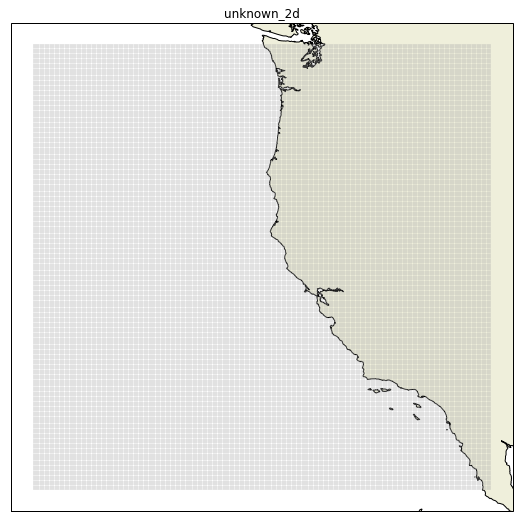

In [11]:
name = 'WestCoastUCSC'
model = models[name]

fig, ax = plot_grid(model['grid'])
get_stats(model['nc'], name, **model['var'])

Most grid are created in such a high resolution that it is quite complicated to create a meaningful visualization even at lower zoom level. The next cell plots only the outline for those grids in an interactive map.

In [12]:
%%time

from concurrent.futures import ThreadPoolExecutor

import folium


m = folium.Map()

for name, model in list(models.items()):
    geojson = model['grid'].outline.__geo_interface__

    df = get_stats(model['nc'], name, **model['var'])
    html = to_html(df)

    gj = folium.GeoJson(geojson, name=name)
    gj.add_child(folium.Popup(html))
    gj.add_to(m)

folium.LayerControl().add_to(m)
m.fit_bounds(m.get_bounds());

CPU times: user 13min 13s, sys: 627 ms, total: 13min 14s
Wall time: 13min 15s


In [13]:
def embed_map(m):
    from IPython.display import HTML

    m.save('index.html')
    with open('index.html') as f:
        html = f.read()

    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%; height: 750px; border: none"></iframe>'
    srcdoc = html.replace('"', '&quot;')
    return HTML(iframe.format(srcdoc=srcdoc))


embed_map(m)